## **Capstone MDS - RandomForestRegressor**

#### **_Integrantes:_**  

1. Evans Díaz   
1. Felipe Ojeda
1. Javier Cofre  
1. Luis Reinoso

In [41]:
# importar librerías
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm
import shap

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint, uniform
from matplotlib.ticker import EngFormatter

In [5]:
# función cálculo R2, RMSE y MSE
def R2_RMSE(y_true, y_pred):
  # cálculo de R2 y RMSE
  r2 = r2_score(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  
  return print('R2:',r2), print('RMSE:',rmse), print('MSE:', mse)

## **_1. Lectura (carga) de los Datos_**

In [6]:
# importamos archivo
#df = pd.read_csv('../Data/df_final_pay_sin_mt.csv')

# importamos archivo desde github (ojo que la rama se llama master)
df = pd.read_csv('https://raw.githubusercontent.com/ecdiazl/capstone-project/master/Data/df_final_pay_sin_mt.csv')

In [7]:
# miramos el dataframe
df.head()

,year_2023,year_2024,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,CAT 798-AC,KOM-CHQ,KOM.960E5,Kom.930E-4,Kom.930E-4SE,Kom.930EN,Kom.930ER,Kom.930ER-MT,Kom.980E5,Komatsu AHS
0,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,96.0,395.0,96.0,240.0,0.0,132.0,24.0
1,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,96.0,396.0,96.0,240.0,0.0,132.0,24.0
2,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,96.0,394.0,96.0,240.0,0.0,132.0,24.0
3,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,95.0,396.0,96.0,240.0,0.0,132.0,24.0
4,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,96.0,395.0,96.0,240.0,0.0,132.0,24.0


In [8]:
# información general df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 84 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year_2023            1567 non-null   bool   
 1   year_2024            1567 non-null   bool   
 2   month_2              1567 non-null   bool   
 3   month_3              1567 non-null   bool   
 4   month_4              1567 non-null   bool   
 5   month_5              1567 non-null   bool   
 6   month_6              1567 non-null   bool   
 7   month_7              1567 non-null   bool   
 8   month_8              1567 non-null   bool   
 9   month_9              1567 non-null   bool   
 10  month_10             1567 non-null   bool   
 11  month_11             1567 non-null   bool   
 12  month_12             1567 non-null   bool   
 13  day_2                1567 non-null   bool   
 14  day_3                1567 non-null   bool   
 15  day_4                1567 non-null   b

## **_2 Preparación del DataFrame_**

In [9]:
# transformamos las variables bool a categorical y le asignamos 0 o 1
for col in df.columns:
  if df[col].dtype == 'bool':
     df[col] = df[col].astype('category').cat.codes
     df[col] = df[col].astype('category') # para que quede como category y no como int8

In [10]:
print('Nombre Columnas: ',df.columns)
print('Cantidad Columnas: ',len(df.columns))

Nombre Columnas:  Index(['year_2023', 'year_2024', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7',
       'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14',
       'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21',
       'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28',
       'day_29', 'day_30', 'day_31', 'shift_B', 'crew_E2', 'crew_E3',
       'crew_E4', 'total', 'efectivo', 'mantencion', 'mecanica', 'electrica',
       'mant_excl', 'mec_excl', 'elec_excl', 'som_excl', 'demora', 'r_prog',
       'r_noprg', 'waiting', 'queued', 'payload', 'distance', 'distance_down',
       'distance_down_level', 'distance_up', 'distance_up_level',
       'expected_time', 'lift_down', 'lift_down_level', 'lift_up',
       'lift_up_level', 'travel_time', 'CAT 797-F', 'CAT 798-AC', 'KOM-CHQ',
       'KOM.96

In [11]:
# cálculamos la desviaicón estándar y la media de payload
std_y = df['payload'].std()
mean_y = df['payload'].mean()

print('Desviación Estándar:',std_y)
print('Media:',mean_y)

Desviación Estándar: 19936.05577427206
Media: 142357.4639507874


In [12]:
# estandarizamos las variables numéricas
col_num = df.drop('payload', axis=1).select_dtypes(include=['float64','int64']).columns

scaler = StandardScaler()
df[col_num] = scaler.fit_transform(df[col_num])

## **_3 Modelo RandomForestRegressor_**

In [13]:
# definimos el tamaño del set de test
test_size = 0.25

In [14]:
# separamos los datos en X e y
X = df.drop('payload', axis=1)
y = df['payload']

# dividimos los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42) 

In [15]:
# Ajustar los hiperparámetros para prevenir el sobreajuste
model = RandomForestRegressor(max_depth=5, min_samples_split=20, min_samples_leaf=10)


In [16]:
# Entrenar el modelo
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=10, min_samples_split=20)

In [17]:
# Realizar predicciones en el conjunto de entrenamiento
predictions_train = model.predict(X_train)

In [18]:
# resultados de R2, RMSE y MSE
R2_RMSE(y_train, predictions_train)

R2: 0.7296771033285061
RMSE: 10388.581117562777
MSE: 107922617.63618189


(None, None, None)

## **_4 Optimización del Modelo_**

### _4.1 Selección de Variables (LassoCV)_

In [19]:
# buscamos alpha optimo con LassoCV
alpha_values = np.linspace(0.01, 300, 3000)

# Crea un objeto LassoCV
lasso_cv = LassoCV(alphas=alpha_values, cv=5)

# Ajusta el modelo a los datos de entrenamiento
lasso_cv.fit(X_train, y_train)

# Valor óptimo de alpha
best_alpha = lasso_cv.alpha_

# Evalúa el modelo en el conjunto de prueba
score = lasso_cv.score(X_test, y_test)

print(f"Mejor valor de alpha: {best_alpha}")
print(f"Puntuación en el conjunto de prueba: {score}")

/opt/homebrew/Caskroom/miniconda/base/envs/py312/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38432019.166259766, tolerance: 37899946.791342594
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/Caskroom/miniconda/base/envs/py312/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 150263522.5585327, tolerance: 37899946.791342594
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/Caskroom/miniconda/base/envs/py312/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 159680050.34762573, tolerance: 37899946.791342594
  model = cd_fast.enet_coordinat

Mejor valor de alpha: 49.424824941647216
Puntuación en el conjunto de prueba: 0.7094203814425775


/opt/homebrew/Caskroom/miniconda/base/envs/py312/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41763313.74497986, tolerance: 37259803.06700942
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/Caskroom/miniconda/base/envs/py312/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133389232.89068604, tolerance: 37259803.06700942
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/Caskroom/miniconda/base/envs/py312/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315442547.4451294, tolerance: 37259803.06700942
  model = cd_fast.enet_coordinate_de

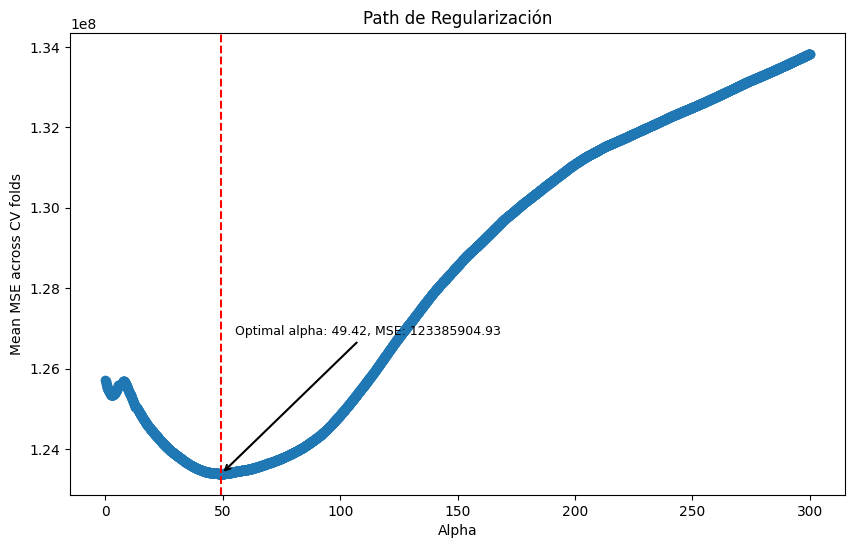

In [20]:
# Graficar MSE vs. Alpha
plt.figure(figsize=(10,6))
plt.plot(lasso_cv.alphas_, np.mean(lasso_cv.mse_path_, axis=1), '-o')
plt.xlabel('Alpha')
plt.ylabel('Mean MSE across CV folds')
plt.title('Path de Regularización')
plt.axvline(lasso_cv.alpha_, color='red', linestyle='--')

# Anotar el valor óptimo de alpha en el gráfico
plt.annotate(f'Optimal alpha: {lasso_cv.alpha_:.2f}, MSE: {np.min(np.mean(lasso_cv.mse_path_, axis=1)):.2f}',
             xy=(lasso_cv.alpha_, np.min(np.mean(lasso_cv.mse_path_, axis=1))),
             xycoords='data', xytext=(10,100), 
             textcoords='offset points',
             arrowprops=dict(arrowstyle="->", lw=1.5),
             fontsize=9)

plt.show()

In [21]:
# Aplicar Lasso para la selección de características
lasso = Lasso(alpha=lasso_cv.alpha_)  
lasso.fit(X_train, y_train)

# Seleccionar las características que tienen coeficientes no nulos
selected_features = X_train.columns[lasso.coef_ != 0]

print("Características seleccionadas:")
print(selected_features)


Características seleccionadas:
Index(['year_2024', 'month_3', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
       'day_10', 'day_11', 'day_13', 'day_17', 'day_20', 'day_21', 'day_22',
       'day_23', 'day_27', 'day_28', 'day_30', 'day_31', 'shift_B', 'crew_E2',
       'crew_E4', 'efectivo', 'mantencion', 'mecanica', 'electrica',
       'mant_excl', 'mec_excl', 'elec_excl', 'demora', 'r_prog', 'r_noprg',
       'waiting', 'queued', 'distance_down_level', 'distance_up',
       'expected_time', 'lift_down', 'lift_down_level', 'travel_time',
       'CAT 797-F', 'CAT 798-AC', 'KOM-CHQ', 'Kom.930E-4', 'Kom.930E-4SE',
       'Kom.930ER-MT', 'Komatsu AHS'],
      dtype='object')


In [22]:
len(selected_features)

53

> Volvemos ajustar el modelo con las variables seleccionadas

In [23]:
# separamos los datos en train y test
X_lasso= df[selected_features]
y_lasso = df['payload']

# dividimos los datos en train y test
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X_lasso, y_lasso, test_size=test_size, random_state=42)

In [24]:
# Inicializar el regresor RandomForest
model_lasso = RandomForestRegressor(max_depth=5, min_samples_split=20, min_samples_leaf=10)



In [25]:
# Entrenar el modelo RandomForest
model_lasso.fit(X_train_lasso, y_train_lasso)

RandomForestRegressor(max_depth=5, min_samples_leaf=10, min_samples_split=20)

#### 4.1.1 Predicciones en el conjunto de entrenamiento

In [26]:
# Realizar predicciones con el modelo entrenado
predictions_lasso_train = model_lasso.predict(X_train_lasso)

In [27]:
# Evaluar la precisión del modelo
mse = mean_squared_error(y_train_lasso, predictions_lasso_train)
print(f'Mean Squared Error of Random Forest Regressor: {mse:.2f}')

Mean Squared Error of Random Forest Regressor: 106867915.62


In [28]:
# resultado de R2, RMSE y MSE
R2_RMSE(y_train_lasso, predictions_lasso_train)

R2: 0.7323189045478525
RMSE: 10337.693921988113
MSE: 106867915.62471


(None, None, None)

#### 4.1.2 Predicciones en el conjunto de testeo

In [29]:
# Realizar predicciones con el modelo entrenado
predictions_lasso_test = model_lasso.predict(X_test_lasso)

In [30]:
# Evaluar la precisión del modelo
mse = mean_squared_error(y_test_lasso, predictions_lasso_test)
print(f'Mean Squared Error of Random Forest Regressor: {mse:.2f}')

Mean Squared Error of Random Forest Regressor: 135511454.66


In [31]:
# resultado de R2, RMSE y MSE
R2_RMSE(y_test_lasso, predictions_lasso_test)

R2: 0.6534732487721158
RMSE: 11640.938736396585
MSE: 135511454.66453853


(None, None, None)

### _4.2 Optimización de Hiperparámetros_

In [32]:
# Definir los hiperparámetros para la búsqueda
param_dist_tree = {
    'n_estimators': randint(1, 300), # número de árboles en el bosque
    'max_depth': randint(1, 300),
    'min_samples_split': randint(2, 300),
    'min_samples_leaf': randint(1, 300),
    'max_features':  [None, 'auto', 'sqrt', 'log2'],
    'min_impurity_decrease': uniform(0,1),
    'bootstrap': [True, False]
}

# Crear la búsqueda de hiperparámetros para DecisionTreeRegressor
random_search_tree = RandomizedSearchCV(
    estimator=RandomForestRegressor(),
    param_distributions=param_dist_tree,
    n_iter=1000,
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

# Ajustar el modelo
random_search_tree.fit(X_train_lasso, y_train_lasso)

# Mejor combinación de hiperparámetros para el árbol de decisión
best_params_tree = random_search_tree.best_params_
print("Best parameters for RandomForestRegressor: ", best_params_tree)


/opt/homebrew/Caskroom/miniconda/base/envs/py312/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1240 fits failed out of a total of 5000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
645 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/py312/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/py312/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/homebrew/Caskroom/miniconda/base/envs/py312/lib/python3.12/site

Best parameters for RandomForestRegressor:  {'bootstrap': True, 'max_depth': 173, 'max_features': None, 'min_impurity_decrease': np.float64(0.8713152472468535), 'min_samples_leaf': 10, 'min_samples_split': 35, 'n_estimators': 36}


In [33]:
# Crear el DecisionTreeRegressor con los mejores parámetros encontrados
best_tree = RandomForestRegressor(**best_params_tree)

In [34]:
# Entrenar el modelo DecisionTreeRegressor con los mejores hiperparámetros
best_tree.fit(X_train_lasso, y_train_lasso)

RandomForestRegressor(max_depth=173, max_features=None,
                      min_impurity_decrease=np.float64(0.8713152472468535),
                      min_samples_leaf=10, min_samples_split=35,
                      n_estimators=36)

In [35]:
# Realizar predicciones en el conjunto de entrenamiento
train_predictions = best_tree.predict(X_train_lasso)

# Realizar predicciones en el conjunto de prueba
test_predictions = best_tree.predict(X_test_lasso)

In [36]:
# Evaluar el modelo en el conjunto de entrenamiento
train_r2 = r2_score(y_train_lasso, train_predictions)
train_mse = mean_squared_error(y_train_lasso, train_predictions)
train_rmse = np.sqrt(train_mse)

print(f"R2 en el conjunto de entrenamiento: {train_r2:.3f}")
print(f"RMSE en el conjunto de entrenamiento: {train_rmse:.2f}")

R2 en el conjunto de entrenamiento: 0.766
RMSE en el conjunto de entrenamiento: 9660.80


In [37]:
train_r2, train_mse, train_rmse

(0.7662256018973121,
 np.float64(93331143.20029199),
 np.float64(9660.804479974326))

In [38]:
# Evaluar el modelo en el conjunto de prueba
test_r2 = r2_score(y_test_lasso, test_predictions)
test_mse = mean_squared_error(y_test_lasso, test_predictions)
test_rmse = np.sqrt(test_mse)

print(f"R2 en el conjunto de prueba: {test_r2:.3f}")
print(f"RMSE en el conjunto de prueba: {test_rmse:.2f}")

R2 en el conjunto de prueba: 0.664
RMSE en el conjunto de prueba: 11460.87


In [39]:
test_r2, test_mse, test_rmse

(0.6641111551351626,
 np.float64(131351434.80825439),
 np.float64(11460.86536035802))

### _4.3 Importancia de las Variables_

#### 4.3.1. Método Shaplley

  0%|          | 0/392 [00:00<?, ?it/s]

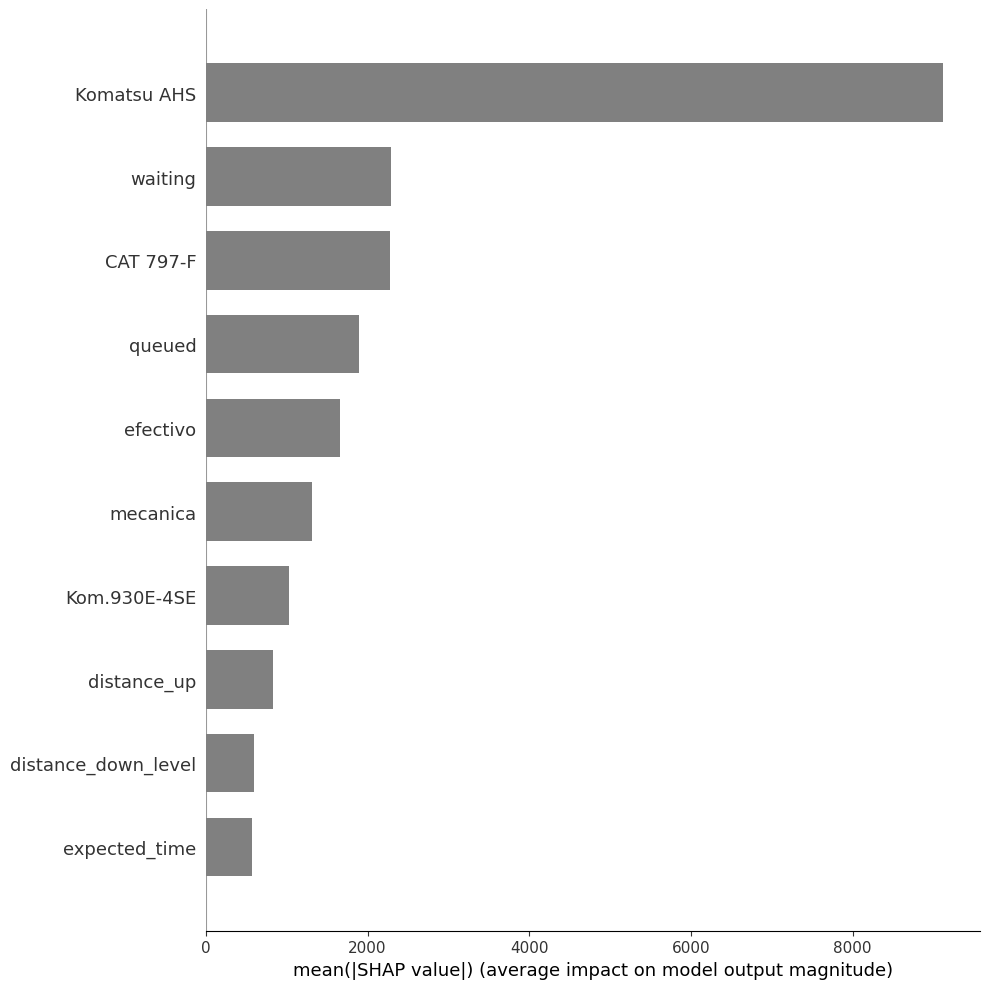

In [50]:
# Crear un muestreo de fondo para el kernelExplainer
background = shap.sample(X_train_lasso, 100)

# Crear el objeto explainer SHAP con el modelo entrenado
explainer = shap.KernelExplainer(best_tree.predict, background)
shap_values = explainer(X_test_lasso)

# Visualizar la importancia de las características
shap.summary_plot(shap_values, 
                  X_test_lasso, 
                  feature_names=X_test_lasso.columns, 
                  plot_type='bar', 
                  color='gray',
                  max_display=10,
                  plot_size=(10, 10))

# Mostrar la gráfica
plt.show()

#### 4.3.2. Método Features Importance

In [46]:
# Mostrar importancia de las características
df_importance = pd.DataFrame({'Feature': X_train_lasso.columns, 
                              'Importance': best_tree.feature_importances_})

# Ordenar las características por importancia
df_importance = df_importance.sort_values('Importance', ascending=False)
df_importance

,Feature,Importance
52,Komatsu AHS,0.351695
38,waiting,0.142248
46,CAT 797-F,0.100560
28,efectivo,0.068759
41,distance_up,0.048272
39,queued,0.045796
30,mecanica,0.043339
50,Kom.930E-4SE,0.035038
42,expected_time,0.026749
40,distance_down_level,0.023447
